# Chapter 6 - Model-agnostic versus Model-specific Explainability

SHAP values show the impact of each feature for a given prediction and the overall model behavior in the decision-making process. This notebook provides a walkthrough of assessing explainability using **KernelSHAP**, a model-agnostic method implemented in the SHAP library. We will use the [pet adoption dataset](https://github.com/aws-samples/aws-machine-learning-university-accelerated-tab/tree/master/data/review) consolidated by [Amazon Machine Learning University(MLU)](https://aws.amazon.com/machine-learning/mlu/). This notebook is tested with TensorFlow 2.10.1 and Python 3.9.10 using Amazon SageMaker Studio ml.m5.8xlarge general-purpose instance with 32 vCPU and 128 GiB. [Link](https://aws.amazon.com/sagemaker/pricing/) for instance pricing reference. Alternatively, you can try this on your preferred IDE.

## Install and load libraries

In [2]:
#install SHAP

!pip install shap imblearn

In [3]:
# Load libraries

%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import shap
import os
import re
import string
from platform import python_version
import warnings

warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

TensorFlow version: 2.10.1
Python version: 3.9.10


## Prepare the dataset

Load and explore the pet_adoption.csv dataset. Data schema:
- **Pet ID** - Unique ID of pet
- **Outcome Type** - State of pet at the time of recording the outcome (0 = not placed, 1 = placed). This is the target label to predict.
- **Sex upon Outcome** - Sex of pet at outcome
- **Name** - Name of pet
- **Found Location** - Found location of pet before entered the center
- **Intake Type** - Circumstances bringing the pet to the center
- **Intake Condition** - Health condition of pet when entered the center
- **Pet Type** - Type of pet
- **Sex upon Intake** - Sex of pet when entered the center
- **Breed** - Breed of pet
- **Color** - Color of pet
- **Age upon Intake Days** - Age of pet when entered the center (days)
- **Age upon Outcome Days** - Age of pet at outcome (days)

In [4]:
# Load dataset and drop Pet ID column

df = pd.read_csv('./pet_adoption.csv')
df = df.drop(['Pet ID'], axis=1)
df.head(5)

,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days
0,1.0,Neutered Male,Chunk,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby/White,730.0,730.0
1,1.0,Neutered Male,Gizmo,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,Chihuahua Shorthair Mix,White/Brown,365.0,365.0
2,0.0,Intact Male,NaN,12034 Research in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,Orange Tabby,6.0,6.0
3,1.0,Neutered Male,*Donatello,2300 Waterway Bnd in Austin (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black,60.0,60.0
4,1.0,Neutered Male,*Zeus,4701 Staggerbrush Rd in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,White/Orange Tabby,7.0,60.0


In [5]:
# Drop rows that contain missing values

data = df.dropna()
data.isna().sum()

Outcome Type             0
Sex upon Outcome         0
Name                     0
Found Location           0
Intake Type              0
Intake Condition         0
Pet Type                 0
Sex upon Intake          0
Breed                    0
Color                    0
Age upon Intake Days     0
Age upon Outcome Days    0
dtype: int64

Converts categorical columns to numerical values and create new feature columns.

In [6]:
# Use LabelEncoder to normalize and encode categorical columns to numerical values.

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data['Pet Type'])
data['categorical_pet_type'] = le.transform(data['Pet Type'])

le = preprocessing.LabelEncoder()
le.fit(data['Intake Condition'])
data['categorical_intake_cond'] = le.transform(data['Intake Condition'])

le = preprocessing.LabelEncoder()
le.fit(data['Sex upon Intake'])
data['categorical_sex_intake'] = le.transform(data['Sex upon Intake'])

le = preprocessing.LabelEncoder()
le.fit(data['Sex upon Outcome'])
data['categorical_sex_outcome'] = le.transform(data['Sex upon Outcome'])


data.head(5)

,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days,categorical_pet_type,categorical_intake_cond,categorical_sex_intake,categorical_sex_outcome
0,1.0,Neutered Male,Chunk,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby/White,730.0,730.0,1,5,2,2
1,1.0,Neutered Male,Gizmo,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,Chihuahua Shorthair Mix,White/Brown,365.0,365.0,2,5,1,2
3,1.0,Neutered Male,*Donatello,2300 Waterway Bnd in Austin (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black,60.0,60.0,1,5,1,2
4,1.0,Neutered Male,*Zeus,4701 Staggerbrush Rd in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,White/Orange Tabby,7.0,60.0,1,6,1,2
6,1.0,Neutered Male,Artemis,9200 N Plaza Dr in Austin (TX),Stray,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Blue/White,2555.0,2555.0,1,5,2,2


Clean textual features.

In [7]:
# Prepare text cleaning function

def preprocess_text(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

# Vectorize text features

from tensorflow.keras import layers

tf.keras.utils.set_random_seed(42)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=preprocess_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [8]:
vectorize_layer.adapt(data['Breed'])
vector_breed = vectorize_layer(data['Breed'])
vector_breed = vector_breed.numpy()
data['Breed'] = vector_breed

In [9]:
vectorize_layer.adapt(data['Color'])
vector_color = vectorize_layer(data['Color'])
vector_color = vector_color.numpy()
data['Color'] = vector_color

In [10]:
vectorize_layer.adapt(data['Found Location'])
vector_fl = vectorize_layer(data['Found Location'])
vector_fl = vector_fl.numpy()
data['Found Location'] = vector_fl

In [11]:
data.head(5)

,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days,categorical_pet_type,categorical_intake_cond,categorical_sex_intake,categorical_sex_outcome
0,1.0,Neutered Male,Chunk,3,Owner Surrender,Normal,Cat,Neutered Male,4,2,730.0,730.0,1,5,2,2
1,1.0,Neutered Male,Gizmo,50,Stray,Normal,Dog,Intact Male,9,12,365.0,365.0,2,5,1,2
3,1.0,Neutered Male,*Donatello,236,Stray,Normal,Cat,Intact Male,4,5,60.0,60.0,1,5,1,2
4,1.0,Neutered Male,*Zeus,432,Stray,Nursing,Cat,Intact Male,4,50,7.0,60.0,1,6,1,2
6,1.0,Neutered Male,Artemis,450,Stray,Normal,Cat,Neutered Male,4,15,2555.0,2555.0,1,5,2,2


Filter numerical columns.

In [12]:
import numpy as np
numerical_features_all = data.select_dtypes(include=np.number).columns
print('Numerical columns:',numerical_features_all)

print('')

categorical_features_all = data.select_dtypes(include='object').columns
print('Categorical columns:',categorical_features_all)

Numerical columns: Index(['Outcome Type', 'Found Location', 'Breed', 'Color',
       'Age upon Intake Days', 'Age upon Outcome Days', 'categorical_pet_type',
       'categorical_intake_cond', 'categorical_sex_intake',
       'categorical_sex_outcome'],
      dtype='object')

Categorical columns: Index(['Sex upon Outcome', 'Name', 'Intake Type', 'Intake Condition',
       'Pet Type', 'Sex upon Intake'],
      dtype='object')


The model will train on numerical features.

In [13]:
numerical_features = data[numerical_features_all]
numerical_features

,Outcome Type,Found Location,Breed,Color,Age upon Intake Days,Age upon Outcome Days,categorical_pet_type,categorical_intake_cond,categorical_sex_intake,categorical_sex_outcome
0,1.0,3,4,2,730.0,730.0,1,5,2,2
1,1.0,50,9,12,365.0,365.0,2,5,1,2
3,1.0,236,4,5,60.0,60.0,1,5,1,2
4,1.0,432,4,50,7.0,60.0,1,6,1,2
6,1.0,450,4,15,2555.0,2555.0,1,5,2,2
...,...,...,...,...,...,...,...,...,...,...
63887,1.0,2425,20,17,1460.0,1460.0,2,5,2,2
63889,1.0,3,8,24,2555.0,2555.0,2,5,3,3
63890,1.0,3,19,7,1825.0,1825.0,2,5,3,3
63892,0.0,421,9,16,730.0,730.0,2,5,1,1


In [14]:
# Assign model features and target to variables.

X = data[numerical_features.columns.drop('Outcome Type')]
y = data['Outcome Type']

In [15]:
# Convert DataFrame to a NumPy array.

X.to_numpy(dtype=str)
y.to_numpy(dtype=str)

array(['1.0', '1.0', '1.0', ..., '1.0', '0.0', '0.0'], dtype='<U32')

In [16]:
# Split the data into 80% training and 20% testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Train a Model

Here, we are ready to build a simple neural network for predicting target Outcome Type.

In [17]:
# Build a simple model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [18]:
#Compile model

model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

m = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
Extension horovod.torch has not been built: /usr/local/lib/python3.9/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-39-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.
[2022-12-19 01:55:41.353 tensorflow-2-10-cpu--ml-m5-8xlarge-a44dc8e523e3c5b857545a3b5683:2759 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-19 01:55:41.578 tensorflow-2-10-cpu--ml-m5-8xlarge-a44dc8e523e3c5b857545a3b5683:2759 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
992/992 [==============================] - 4s 3ms/step - loss: 3.6640 - accuracy: 0.7320 - precision: 0.7383 - recall: 0.9867
Epoch 2/10
992/992 [==============================] - 3s 3ms/step - loss: 0.5812 - accuracy: 0.7376 - precision: 0.7381 - recall: 0.9991
Epoch 3/10
992/992 [===========

## Explain a Model

Here, we can visualize SHAP values using different plots provided by SHAP.

In [19]:
# Instantiates KernelExplainer
e = shap.KernelExplainer(model, X_train)

# Subsamples a data set for efficiency. Use e.shap_values(X_test) to run full computation which will take longer to complete for large test dataset.
shap_values = e.shap_values(shap.sample(X_test,10))
#shap_values = e.shap_values(X_test)

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = [ 2.24497705e-32  2.24497705e-32  2.24497705e-32  2.24497705e-32
  2.24497705e-32 -2.80622132e-32 -2.80622132e-32 -2.80622132e-32
 -2.80622122e-32]
INFO:shap:num_full_subsets = 4
INFO:shap:phi = [-3.98053124e-07  2.17440570e-06 -3.98053124e-07 -3.98053124e-07
 -3.98053124e-07 -1.72806581e-07  7.94093388e-23 -3.98053124e-07
 -1.13334950e-08]
INFO:shap:num_full_subsets = 4
INFO:shap:phi = [-2.64697796e-23  1.39139291e-06 -1.87366326e-07 -3.78629056e-07
 -3.78629056e-07 -1.74422305e-07  1.32348898e-22 -2.51140426e-07
 -2.12057376e-08]
INFO:shap:num_full_subsets = 4
INFO:shap:phi = [-3.98053124e-07  2.17440570e-06 -3.98053124e-07 -3.98053124e-07
 -3.98053124e-07 -1.72806581e-07  7.94093388e-23 -3.98053124e-07
 -1.13334950e-08]
INFO:shap:num_full_subsets = 4
INFO:shap:phi = [-4.28601924e-07  1.76899044e-06  1.11309920e-07 -4.28601924e-07
 -4.28601924e-07 -1.21241504e-07  1.05879118e-22 -4.28601924e-07
 -4.46511592e-08]
INFO:shap:num_full_subset

### Force Plot

The SHAP force plot shows which features influenced the model’s prediction for a single observation. Starting at the base value, we can see the increment or decrement of each feature leads us to the final prediction for this sample. Red means the feature pushes the prediction higher to the right, while blue push a lower value prediction to the left. 

In [20]:
# N is the sample index to explain.
n = 9

shap.force_plot(e.expected_value, shap_values[0][n,:], X_test.iloc[n,:])

### Decision Plot

We can aggregate and visualize SHAP values using a decision plot to understand the overall model behavior in decision-making. The features are ordered by descending importance, and the lines move upwards from the bottom at a base value to their final prediction. The X-axis represents SHAP values for each feature on the y-axis.

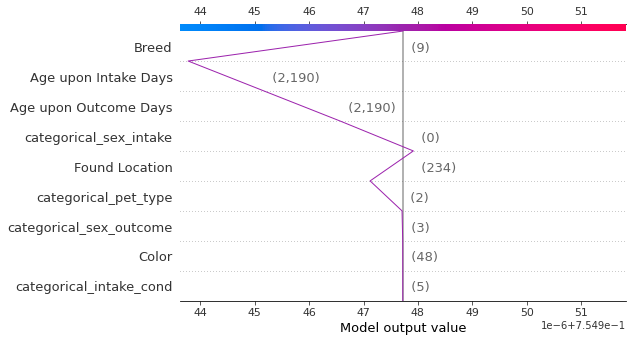

In [21]:
# Visualize a decision_plot

shap.decision_plot(e.expected_value, shap_values[0][n,:], X_test.iloc[n,:])

### Summary Bar Plot

The summary bar plot shows the mean absolute SHAP values for each feature across all observations.

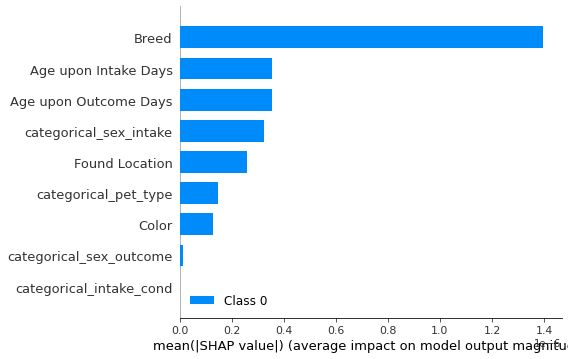

In [22]:
shap.summary_plot(shap_values, X_test)

Calculating Shapley values with large datasets using Kernel SHAP can be time-consuming and computationally intensive. To improve the runtime and enhance scalability, Amazon SageMaker Clarify parallelizes SHAP computation. Refer to [Amazon SageMaker Clarify: Machine Learning Bias Detection and Explainability in the Cloud](https://assets.amazon.science/45/76/30bab4f14ccab96cfe8067ed2b4a/amazon-sagemaker-clarify-machine-learning-bias-detection-and-explainability-in-the-cloud.pdf) for more info on Amazon SageMaker Clarify and Kernel SHAP.